In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
#read saved csv file
conComplaintDf=pd.read_csv("Consumer_Complaints.csv",converters={'ZIP code': lambda x: str(x)})

#ccDf=conComplaintDf.groupby(['Company response to consumer']).count()


In [2]:
#order the responses
#0 closed with monetary relief
#1 closed with non-monetary relief
#2 closed with relief
#3 closed with explanation
#4 closed
#5 closed without relief
#6 untimely response
#7 in progress
conComplaintDf['respCode']=np.where(conComplaintDf['Company response to consumer']== 'Closed with monetary relief',0,
    np.where(conComplaintDf['Company response to consumer']== 'Closed with non-monetary relief',1,
        np.where(conComplaintDf['Company response to consumer']== 'Closed with relief',2,
            np.where(conComplaintDf['Company response to consumer']== 'Closed with explanation',3,
                np.where(conComplaintDf['Company response to consumer']== 'Closed',4,
                    np.where(conComplaintDf['Company response to consumer']== 'Closed without relief',5,
                        np.where(conComplaintDf['Company response to consumer']== 'Untimely response',6,
                            np.where(conComplaintDf['Company response to consumer']== 'In progress',7,8))))))))

In [3]:
#clean the date received field
#convert 'date received' column from string to datetime
#align all complaints to end of month 
#create a month-year column

import calendar
import datetime

#conComplaintDfStg['Date received'].dtype
conComplaintDf['dateRec']=pd.to_datetime(conComplaintDf['Date received'])#,format='%B/%d/%y')
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


In [4]:
#drop rows without complete information(6&7) create data frames for EDA

#conComplaintDfStg=
conComplaintDf.drop(conComplaintDf[conComplaintDf.respCode >=6].index, inplace=True)
conComplaintDf['zip3']=conComplaintDf['ZIP code'].str[:3]


#create dataframe with complaints resulting in monetary relief
response0Df=conComplaintDf.loc[(conComplaintDf.respCode== 0)]
                               

In [5]:
#don't use this file <- delete
#urban area to cbsa and urban area to zip code file from census site 
#merge files then merge onto consumer complaint data set

#download urban area to zip5 file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_zcta_rel_10.txt"
uaToZipDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)},encoding='latin1')
uaToZipDf=uaToZipDf[['UA','UANAME','ZCTA5','ZPOP']]
uaToZipDf.drop(uaToZipDf[uaToZipDf.UA==99999].index,inplace=True)
#uaToZipDf.head(10)

In [125]:
#download urban area to cbsa file
#UA:urban area number
#UANAME: urban area name
#CBSA: corebased statistical area number(micro/metropolitan statistical area)
#MNAME: cbsa name
#MEMI: 1=metropolitan statistical area; 2=micropolitan statistical area
url="https://www2.census.gov/geo/docs/maps-data/data/rel/ua_cbsa_rel_10.txt"
uaToCbsaDf=pd.read_csv(url,encoding='latin1')#converters={'ZCTA5': lambda x: str(x)})
uaToCbsaDf=uaToCbsaDf[['UA','UANAME','CBSA','MNAME','MEMI','POPPT']]
uaToCbsaDf.drop(uaToCbsaDf[(uaToCbsaDf.MEMI != 1) | (uaToCbsaDf.UA== 99999)|(uaToCbsaDf.CBSA==99999) ].index, inplace=True)



In [71]:
#this part isn't needed-> yes it is!
#download zip to cbsa file

import urllib.request
import requests
import io
url="https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt"
#zipToSaDf=pd.read_csv(url,'ZCTA5',index_col=0)
#preserve leading zeros in zip5
zipToSaDf=pd.read_csv(url,converters={'ZCTA5': lambda x: str(x)})
zipToSaDf=zipToSaDf[['ZCTA5','CBSA','ZPOP','MEMI']]
zipToSaDf.drop(zipToSaDf[(zipToSaDf.MEMI)!=1].index,inplace=True)
zipToSaDf['zip3']=zipToSaDf.ZCTA5.str[:3]
zipToSaDf.head(10)

#testfile= urllib.request.urlretrieve("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt","zipToSa.txt")
#zipToSaData= urllib.request.urlopen("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt")
#zipToSaDf= pd.read_csv(io.StringIO(zipToSaData.decode(utf-8)))
#testfile.retrieve("https://www2.census.gov/geo/docs/maps-data/data/rel/zcta_cbsa_rel_10.txt","zipToSa.txt")


,ZCTA5,CBSA,ZPOP,MEMI,zip3
2,00602,10380,41520,1,006
3,00603,10380,54689,1,006
4,00606,41900,6615,1,006
5,00606,49500,6615,1,006
6,00610,10380,29016,1,006
7,00612,41980,67010,1,006
8,00616,41980,11017,1,006
9,00617,41980,24597,1,006
10,00622,41900,7853,1,006
11,00623,41900,43061,1,006


In [8]:
#split the cfpb data into two files
#1.) with full 5-digit zip code
#2.) with 3-digit zip code
conComplaintZ5=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==False]

conComplaintZ3=conComplaintDf[conComplaintDf['ZIP code'].str.contains("XX")==True]


In [9]:
#remove extra zip3 observations from zipToSaDf
#sort by zip3 and zip-level population
#goal is to keep zip3 with largest population- 
zipToSaDf.sort_values(['zip3','ZPOP'])
zipToSaDfZ3=zipToSaDf.drop_duplicates(['zip3'],keep='last')


In [10]:
#merge the zip To CBSA file onto the consumer complaint data
cfpbComplaintCbsaZ5= pd.merge(conComplaintZ5,zipToSaDf,left_on=['ZIP code','zip3'],right_on=['ZCTA5','zip3'],how='left')
cfpbComplaintCbsaZ3= pd.merge(conComplaintZ3,zipToSaDfZ3,on=['zip3'],how='left')


In [11]:
#concatenate the zip5 and zip3 files
cfpbComplaintCbsa= pd.concat([cfpbComplaintCbsaZ5,cfpbComplaintCbsaZ3])
#cfpbComplaintCbsa.drop(['zip3_x','zip3_y'],axis=1)
#cfpbComplaintCbsa.head(10)


In [120]:
cfpbComplaintCbsa['CBSA'].count()

784536

In [119]:
uaCbsaDf['CBSA'].count()

1962

In [131]:
cfpbComplaintCbsaUa.count()

Date received                   719868
Product                         719868
Sub-product                     501747
Issue                           719868
Sub-issue                       294063
Consumer complaint narrative    153333
Company public response         186413
Company                         719868
State                           719863
ZIP code                        719868
Tags                             99531
Consumer consent provided?      273937
Submitted via                   719868
Date sent to company            719868
Company response to consumer    719868
Timely response?                719868
Consumer disputed?              715728
Complaint ID                    719868
respCode                        719868
dateRec                         719868
adjDate                         719868
monYear                         719868
zip3                            719868
ZCTA5                           719868
CBSA                            719868
ZPOP                     

In [129]:

#UA to CBSA is a one to many relationship. keep CBSA with largest population for this exercise
uaToCbsaDf.sort_values(['CBSA','POPPT'],inplace=True)
uaToCbsaDf=uaToCbsaDf.drop_duplicates(['CBSA'],keep='last')
#uaToCbsaDf.head(100)


,UA,UANAME,CBSA,MNAME,MEMI,POPPT
13,280,"Abilene, TX Urbanized Area",10180,"Abilene, TX Metro Area",1.0,110421
25,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...",10380,"Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,279465
33,766,"Akron, OH Urbanized Area",10420,"Akron, OH Metro Area",1.0,514095
40,901,"Albany, GA Urbanized Area",10500,"Albany, GA Metro Area",1.0,95779
45,970,"Albany--Schenectady, NY Urbanized Area",10580,"Albany-Schenectady-Troy, NY Metro Area",1.0,594962
55,1171,"Albuquerque, NM Urbanized Area",10740,"Albuquerque, NM Metro Area",1.0,741318
60,1279,"Alexandria, LA Urbanized Area",10780,"Alexandria, LA Metro Area",1.0,82804
68,1495,"Allentown, PA--NJ Urbanized Area",10900,"Allentown-Bethlehem-Easton, PA-NJ Metro Area",1.0,628839
85,1792,"Altoona, PA Urbanized Area",11020,"Altoona, PA Metro Area",1.0,79930
90,1927,"Amarillo, TX Urbanized Area",11100,"Amarillo, TX Metro Area",1.0,196651


In [115]:
cfpbComplaintCbsa.CBSA.nunique()

375

In [90]:
#change the dtype from float to int
cfpbComplaintCbsa['CBSA']=cfpbComplaintCbsa['CBSA'].fillna(0.0).astype(int)


In [130]:
#now merge with the uaCbsa data to add urban area information
cfpbComplaintCbsaUa=pd.merge(cfpbComplaintCbsa,uaToCbsaDf, on='CBSA', how = 'inner')


In [62]:
#this part doesn't work

#import gazeteer files for lat/long data
#from StringIO 
import io
from zipfile import ZipFile
from urllib.request import urlopen
#urlopen

url= request.urlopen("http://www2.census.gov/geo/docs/maps-data/data/gazetteer/Gaz_ua.zip")
zipfile= ZipFile(io.StringIO(url.read()))
f= open(zipfile.NameToInfo.keys()[0],'wb')
f.write(zipfile.open(zipfile.NameToInfo.keys()[0]).read())
f.close()

df = pd.read_csv(zipfile.NameToInfo.keys()[0])

#uaGaz=pd.read_csv(url,compression='zip')#converters={'ZCTA5': lambda x: str(x)})


TypeError: initial_value must be str or None, not bytes

In [67]:
from zipfile import ZipFile
from urllib.request import urlopen   
import pandas as pd
import os

URL = \
    'Ahttp://www2.census.gov/geo/docs/maps-data/data/gazetteer/Gaz_ua.zip'

# open and save the zip file onto computer
url = urlopen(URL)
output = open('zipFile.zip', 'wb')    # note the flag:  "wb"        
output.write(url.read())
output.close()

# read the zip file as a pandas dataframe
uaGaz = pd.read_csv('zipFile.zip',sep='\t',encoding='latin1')   # pandas version 0.18.1 takes zip files       

# if keeping on disk the zip file is not wanted, then:
#os.remove(zipName)   # remove the copy of the zipfile on disk

In [161]:
#keep ID, Lat, Long fields and merge onto cfpb data
#uaGaz.count()
#uaGaz=uaGaz[['GEOID','INTPTLAT','INTPTLONG']]
gazCols=['GEOID','NAME',
 'UATYPE',
 'POP10',
 'HU10',
 'ALAND',
 'AWATER',
 'ALAND_SQMI',
 'AWATER_SQMI',
 'INTPTLAT',
 'INTPTLONG']
uaGaz.columns=gazCols
cfpbComplaintCbsaUaLl= pd.merge(cfpbComplaintCbsaUa,uaGaz,left_on='UA',right_on='GEOID',how='left')
#cfpbComplaintCbsaUaLl.head(10)

In [164]:
list(cfpbComplaintCbsaUaLl)

['Date received',
 'Product',
 'Sub-product',
 'Issue',
 'Sub-issue',
 'Consumer complaint narrative',
 'Company public response',
 'Company',
 'State',
 'ZIP code',
 'Tags',
 'Consumer consent provided?',
 'Submitted via',
 'Date sent to company',
 'Company response to consumer',
 'Timely response?',
 'Consumer disputed?',
 'Complaint ID',
 'respCode',
 'dateRec',
 'adjDate',
 'monYear',
 'zip3',
 'ZCTA5',
 'CBSA',
 'ZPOP',
 'MEMI_x',
 'UA',
 'UANAME',
 'MNAME',
 'MEMI_y',
 'POPPT',
 'GEOID',
 'NAME',
 'UATYPE',
 'POP10',
 'HU10',
 'ALAND',
 'AWATER',
 'ALAND_SQMI',
 'AWATER_SQMI',
 'INTPTLAT',
 'INTPTLONG']

In [158]:
cfpbComplaintCbsaUaLl.iloc[:,-1]
cfpbComplaintCbsaUaLl.rename(columns={'INTPTLONG\n':'INTPTLONG'}, inplace=True)

In [181]:
#Map the Urban Areas
import folium
from IPython.display import HTML
from folium import plugins

MAX_RECORDS=1000
map = folium.Map(location=(37.46,-22.45),zoom_start=12)
                 
                 #[cfpbComplaintCbsaUaLl["INTPTLAT"].mean(), 
                           # cfpbComplaintCbsaUaLl["INTPTLONG"].mean()], 
                            #zoom_start=12)
for each in cfpbComplaintCbsaUaLl[0:MAX_RECORDS].iterrows():
        folium.Marker(location= [each[1]['Y'],each[1]['X']],
            clustered_marker= True)
map.create_map('foo.html')
map
#marker_cluster = folium.MarkerCluster().add_to(complaints_map)
#for name, row in cfpbComplaintCbsaUaLl.iterrows():
#    folium.Marker([row["INTPTLAT"], row["INTPTLONG"]], popup="{0}: {1}".format(row["DBN"], row["school_name"])).add_to(marker_cluster)
#complaints_map.create_map('complaints.html')
#complaints_map

KeyError: 'Y'

In [21]:


#conComplaintDf['zip3']=conComplaintDf['ZIP code'].str[:3]
cbsa.groupby('zip3').MNAME.nunique()


zip3
006      6
007      6
009      1
010      3
011      2
012      1
013      2
014      4
015      5
016      2
017      4
018      4
019      4
020      4
021      4
022      4
023      5
024      4
025      2
026      2
027      5
028      5
029      3
030      4
031      2
032      2
033      2
034      1
038      5
039      2
      ... 
958      1
959      2
960      1
961      2
967      1
968      1
970      3
971      2
972      2
973      3
974      1
975      1
977      1
980      2
981      2
982      4
983      2
984      2
985      3
986      3
988      1
989      2
990      1
992      1
993      2
994      1
995      1
996      1
997      1
999    109
Name: MNAME, dtype: int64

In [47]:
#look at some specific CBSA/ Zip to understand the data
uaToCbsaDf.loc[uaToCbsaDf['CBSA']==10380]


,UA,UANAME,CBSA,MNAME,MEMI
25,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...",10380,"Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0
2398,55738,"MayagÃ¼ez, PR Urbanized Area",10380,"Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0


In [54]:
#uaToZipDf.loc[uaToZipDf['ZCTA5']=='00690']
zipToSaDf.loc[zipToSaDf['CBSA']==10380]

,ZCTA5,CBSA,ZPOP,MEMI
2,00602,10380,41520,1
3,00603,10380,54689,1
6,00610,10380,29016,1
16,00631,10380,1852,1
32,00662,10380,43282,1
36,00669,10380,29744,1
37,00670,10380,9807,1
39,00676,10380,40316,1
40,00677,10380,15272,1
41,00678,10380,27819,1


In [53]:
#cbsa.groupby('ZCTA5').MNAME.nunique()
cbsa.loc[cbsa['CBSA']==10380]

,ZCTA5,CBSA,ZPOP,MEMI_x,UA,UANAME,MNAME,MEMI_y,zip3
0,00602,10380,41520,1,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
1,00602,10380,41520,1,55738,"MayagÃ¼ez, PR Urbanized Area","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
2,00603,10380,54689,1,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
3,00603,10380,54689,1,55738,"MayagÃ¼ez, PR Urbanized Area","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
4,00610,10380,29016,1,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
5,00610,10380,29016,1,55738,"MayagÃ¼ez, PR Urbanized Area","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
6,00631,10380,1852,1,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
7,00631,10380,1852,1,55738,"MayagÃ¼ez, PR Urbanized Area","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
8,00662,10380,43282,1,631,"Aguadilla--Isabela--San SebastiÃ¡n, PR Urbaniz...","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006
9,00662,10380,43282,1,55738,"MayagÃ¼ez, PR Urbanized Area","Aguadilla-Isabela-San SebastiÃ¡n, PR Metro Area",1.0,006


In [ ]:
#merge cbsa-zip file with complaint data
#conCompStgRnd=conComplaintDfStg.set_index(['ZIP code'])
#conCompStgRnd.sort_index()


#cbsaRnd=cbsa.set_index(['ZCTA5'])
#cbsaRnd.sort_index()
conComplaintMsaDf=pd.merge(conComplaintDf,cbsa,left_on=['ZIP code'], right_on=['ZCTA5'],how='inner')
#left_index= True,right_index= True, how='inner')                           #left_on='ZIP code',right_on='ZCTA5',how='left')


KeyboardInterrupt: 

In [ ]:
# Look at length of consumer complaint narrative
conComplaintDf['narrLength']=conComplaintDf['Consumer complaint narrative'].str.len()
zipLen=conComplaintDf['ZIP code'].str.len()
zipLen.describe()
#conComplaintDf
#ccDfConCpltNarr=conComplaintDf.groupby(level=['Company response to consumer','Consumer complaint narrative']).len()

In [ ]:
# look at major fields
conComplaintIndDf=conComplaintDf.set_index(['Company response to consumer','State','ZIP code','Product',
    'Sub-product','narrLength'])
ccDfSt=conComplaintIndDf.groupby(level=['Company response to consumer','State']).count()
ccDfZp=conComplaintIndDf.groupby(level=['Company response to consumer','ZIP code']).count()
ccDfProd=conComplaintIndDf.groupby(level=['Company response to consumer','Product']).count()
ccDfSubProd=conComplaintIndDf.groupby(level=['Company response to consumer','Sub-product']).count()
ccDfNarrLength=conComplaintIndDf.groupby(level=['Company response to consumer','narrLength']).count()


In [8]:

import calendar
import datetime
conComplaintDf['adjDate'] = conComplaintDf['dateRec'].map(
    lambda x: datetime.datetime(
        x.year,
        x.month,
        max(calendar.monthcalendar(x.year, x.month)[-1][:5])
    )
)
conComplaintDf['monYear']=conComplaintDf['adjDate'].apply(lambda x: x.strftime('%B-%Y'))


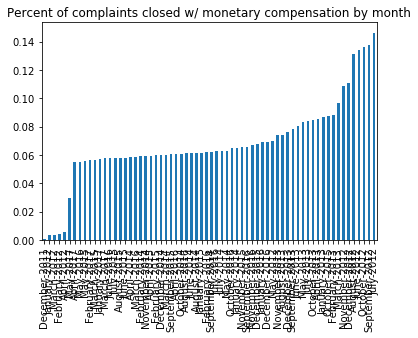

In [17]:

#histograms for month/Year- percent of responses w/monetary compensation of all complaints
monYearAll=conComplaintDf.monYear.value_counts()
monYear0=response0Df.monYear.value_counts()
resp0MonYearPct=monYear0/monYearAll
resp0MonYearPct.sort_values(inplace=True)
#resp0MonYearPct

resp0MonYearPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by month')
plt.xlabel('Month')
plt.ylabel('Percent')
plt.show()



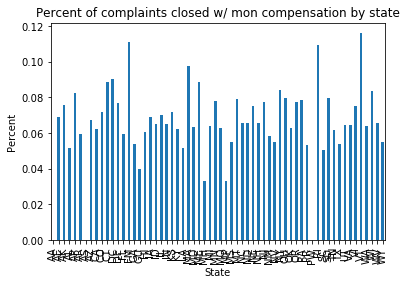

In [23]:
#histograms for state- percent of responses w/monetary compensation of all complaints
stateAll=conComplaintDf.State.value_counts()
state0=response0Df.State.value_counts()
resp0StatePct=state0/stateAll
resp0StatePct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by state')
plt.xlabel('State')
plt.ylabel('Percent')
plt.show()


#plot(kind='bar')
#conComplaintDf.'ZIP code'.value_counts().plot(kind='bar')



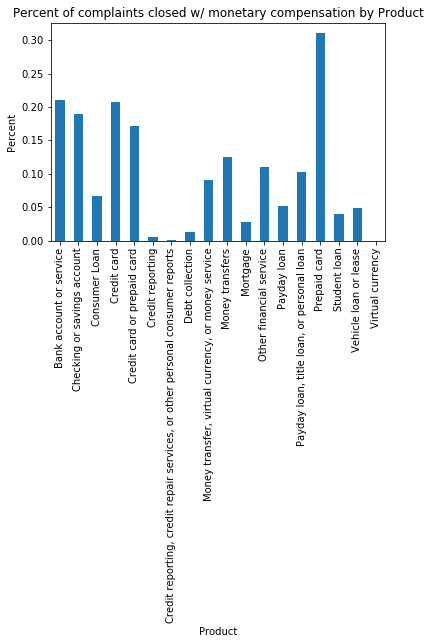

In [36]:
#histograms for Product- percent of responses w/monetary compensation of all complaints
prodAll=conComplaintDf.Product.value_counts()
prod0=response0Df.Product.value_counts()
resp0ProdPct=prod0/prodAll
resp0ProdPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by Product')
plt.xlabel('Product')
plt.ylabel('Percent')
plt.show()




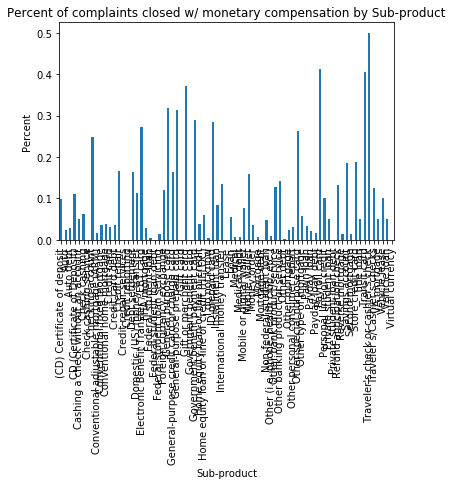

In [35]:
#histograms for product
#histograms for Product- percent of responses w/monetary compensation of all complaints
sProdAll=conComplaintDf['Sub-product'].value_counts()
sProd0=response0Df['Sub-product'].value_counts()
resp0SprodPct=sProd0/sProdAll
resp0SprodPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by Sub-product')
plt.xlabel('Sub-product')
plt.ylabel('Percent')
plt.show()


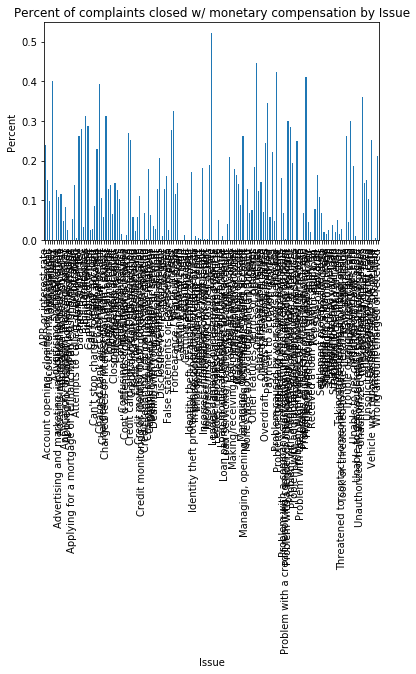

In [182]:
#histograms for Issue
#histograms for Issue- percent of responses w/monetary compensation of all complaints
issAll=conComplaintDf['Issue'].value_counts()
iss0=response0Df['Issue'].value_counts()
resp0IssPct=iss0/issAll
resp0IssPct.plot(kind='bar',title='Percent of complaints closed w/ monetary compensation by Issue')
plt.xlabel('Issue')
plt.ylabel('Percent')
plt.show()

In [229]:
cfpbComplaintCbsaUaLl['Consumer complaint narrative']= cfpbComplaintCbsaUaLl['Consumer complaint narrative'].fillna('')
#replace(np.nan,'',regex=True)
cfpbComplaintCbsaUaLl

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,...,NAME,UATYPE,POP10,HU10,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,03/21/2017,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77075,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
1,04/15/2017,Credit card,NaN,Billing disputes,NaN,,Company has responded to the consumer and the ...,BARCLAYS BANK DELAWARE,TX,77407,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
2,04/17/2017,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,,Company has responded to the consumer and the ...,"CITIBANK, N.A.",TX,77521,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
3,04/05/2017,Debt collection,"Other (i.e. phone, health club, etc.)",Disclosure verification of debt,Not given enough info to verify debt,,Company believes it acted appropriately as aut...,"Blakely-Witt and Associates, Inc.",TX,77078,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
4,02/08/2017,Credit reporting,NaN,Incorrect information on credit report,Information is not mine,,Company has responded to the consumer and the ...,EXPERIAN DELAWARE GP,TX,77584,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
5,04/21/2017,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,,NaN,PORTFOLIO RECOVERY ASSOCIATES INC,TX,77450,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
6,04/20/2017,Debt collection,Credit card,Cont'd attempts collect debt not owed,Debt resulted from identity theft,,NaN,PORTFOLIO RECOVERY ASSOCIATES INC,TX,77521,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
7,03/06/2017,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,,NaN,ENCORE CAPITAL GROUP INC.,TX,77365,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
8,03/26/2017,Mortgage,Conventional fixed mortgage,Settlement process and costs,NaN,,NaN,LOANDEPOT.COM,TX,77381,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531
9,04/26/2017,Debt collection,Payday loan debt,False statements or representation,"Impersonated attorney, law enforcement, or gov...",,NaN,Ad Astra Recovery Services Inc,TX,77026,...,"Houston, TX Urbanized Area",U,4944332,1895670,4299420988,88196119,1660.016,34.053,29.784308,-95.393531


In [236]:
import nltk 
import re
tokenSent= cfpbComplaintCbsaUaLl['Consumer complaint narrative'].apply(nltk.word_tokenize)
#cfpbComplaintCbsaUaLl['tokenSent']= cfpbComplaintCbsaUaLl.apply(lambda x: nltk.word_tokenize(x['Consumer complaint narrative']),axis=1)

#cfpbComplaintFin['tokenSent']= cfpbComplaintFin['ConsumerNarrative'].apply(lambda x: nltk.word_tokenize(x['ConsumerNarrative']),axis=1)


In [237]:
tokenSent

0                                                        []
1                                                        []
2                                                        []
3                                                        []
4                                                        []
5                                                        []
6                                                        []
7                                                        []
8                                                        []
9                                                        []
10                                                       []
11                                                       []
12                                                       []
13                                                       []
14                                                       []
15                                                       []
16                                      

In [212]:
import pandas as pd
import nltk

df = pd.DataFrame({'sentences': ['This is a very good site. I will recommend it to others.', 'Can you please give me a call at 9983938428. have issues with the listings.', 'good work! keep it up']})
df.sentences.dtype
#df['tokenized_sents'] = df.apply(lambda row: nltk.word_tokenize(row['sentences']), axis=1)



dtype('O')